In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import utils
from torchvision.io import image
from torchvision.transforms.functional import to_pil_image
import pandas as pd
import time
import numpy as np

# 类别预测层

In [2]:
# 输出通道数为 num_anchors * (num_classes + 1)，即每个通道都是一个锚框对一个类别的预测
# 卷积核为 3*3 padding=1，图片输出尺寸不变
def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1), kernel_size=3, padding=1)

# 边框预测层

In [3]:
# 输出通道为 num_anchors * 4，即每个通道都是对一个锚框的四个偏移量之一的预测
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

# 连结多尺度的预测

In [4]:
def forward(x, block):
    return block(x)

# 不同特征图的输出尺寸不一样
Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10)) # 输出5*(10+1)=55通道
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10)) # 输出3*(10+1)=33通道
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [5]:
# 1、将通道维移到最后一维
# 2、将尺寸转成2维，(批量大小，高*宽*通道数)
# 3、多特征图输出结果在2维的dim=1上拼接

def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

In [6]:
# 可将不同特征图的输出结果拼接
concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

# 高和宽减半块

In [7]:
# 下采样块，宽高减半
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

In [8]:
X = torch.zeros((2, 3, 20, 20))
forward(X, down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

# 基本网络块

In [9]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

# 给定输入图像为3*256*256，下采样3次
forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

# 完整的模型

In [10]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

In [11]:
def blk_forward(X, blk, area_size, a_w_h_ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = utils.multibox_prior(Y, area_sizes=area_size, w_h_ratios=a_w_h_ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [12]:
area_size = np.array([[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79], [0.88, 0.961]]) ** 2
a_w_h_ratio = [[1, 2, 0.5]] * 5
num_anchors = len(area_size[0]) + len(a_w_h_ratio[0]) - 1

area_size

array([[0.04    , 0.073984],
       [0.1369  , 0.199809],
       [0.2916  , 0.383161],
       [0.5041  , 0.6241  ],
       [0.7744  , 0.923521]])

In [13]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # 即赋值语句self.blk_i=get_blk(i)
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i], num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i], num_anchors))

    def forward(self, X):
        # 每一层的锚框、类别预测、边框预测
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # getattr即访问self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), area_size[i], a_w_h_ratio[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        # anchors shape:(1, 5层的num_boxes_per_pixel * img_h * img_w, 4)
        anchors = torch.cat(anchors, dim=1)
        # cls_preds shape:(批量，5层的num_anchors * (num_classes + 1))
        # 转为 shape:(批量，5层的num_anchors，num_classes + 1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(cls_preds.shape[0], -1, self.num_classes + 1)
        # bbox_preds shape:(批量，5层的锚框数*4)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [14]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


# 训练数据

In [15]:
batch_size = 16
train_iter, _ = utils.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [16]:
device, net = utils.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

In [17]:
# 计算类别预测损失和边框偏移损失

In [18]:
# 损失1

bbox_loss = nn.L1Loss(reduction='none')
cls_loss = nn.CrossEntropyLoss(reduction='none')

In [18]:
# 损失2（其他损失函数）

def smooth_l1(data, scalar):
    """
        平滑L1，在[-1/(scalar^2), 1/(scalar^2)]区间内使用二次函数，区间外使用一次函数，
        scalar控制平滑度（二次函数开口大小/分段函数连接处位置宽窄）
    """
    out = []
    for v in data:
        if abs(v) < 1 / (scalar ** 2):
            out.append(((scalar * v) ** 2) / 2)
        else:
            out.append(abs(v) - 0.5 / (scalar ** 2))
    return torch.tensor(out)

def focal_loss(x, gamma):
    """
        交叉熵损失为-log(x)，焦点损失为-a(1-x)^gamma * log(x)
        增大gamma可以有效地减少正类预测概率较大时（例如x>0.5）的相对损失，因此训练可以更集中在那些错误分类的困难示例上。 
        取a=1
    """
    return -(1 - x) ** gamma * torch.log(x)

def cls_focal_loss(y_hat, y):
    """
        
    """
    focal_log = -focal_loss(F.softmax(y_hat, dim=1), gamma=1.0)
    return F.nll_loss(focal_log, y, reduction='none')

# bbox_loss = lambda x1, x2: smooth_l1(data=x1 - x2, scalar=1.0)
bbox_loss = nn.SmoothL1Loss(reduction='none', beta=1.0)
cls_loss = cls_focal_loss

In [19]:
# 分类loss和边框偏移loss合并，（权重分配默认1:1，可调整）
def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    # print('cls_preds cls_labels shape: ', cls_preds.reshape(-1, num_classes).shape, cls_labels.reshape(-1).shape)
    cls = cls_loss(cls_preds.reshape(-1, num_classes), cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

In [20]:
# 评估
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维。
    return float((cls_preds.argmax(dim=-1).type(cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

In [21]:
num_epochs = 15
net = net.to(device)
for epoch in range(num_epochs):
    # 训练精确度的和，训练精确度的和中的示例数
    # 绝对误差的和，绝对误差的和中的示例数
    cls_acc = 0
    cls_labels_num = 0
    bbox_L1 = 0
    bbox_labels_num = 0
    
    net.train()
    time_0 = time.time()
    for features, target in train_iter:
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # 生成多尺度的锚框，为每个锚框预测类别和偏移量
        anchors, cls_preds, bbox_preds = net(X)
        # 为每个锚框标注偏移量和类别
        bbox_labels, bbox_masks, cls_labels = utils.multibox_target(anchors, Y)
        # 根据类别和偏移量的预测和标注值计算损失函数
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
        l.mean().backward()
        trainer.step()
        
        cls_acc += cls_eval(cls_preds, cls_labels)
        cls_labels_num += cls_labels.numel()
        bbox_L1 += bbox_eval(bbox_preds, bbox_labels, bbox_masks)
        bbox_labels_num += bbox_labels.numel()
    cls_err, bbox_mae = 1 - cls_acc / cls_labels_num, bbox_L1 / bbox_labels_num
    print(f'epoch: {epoch + 1}, cls_err: {cls_err:.2e}, bbox_mae: {bbox_mae:.2e}')
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) * num_epochs / (time.time() - time_0):.1f} examples/sec on '
      f'{str(device)}')

epoch: 1, cls_err: 1.28e-02, bbox_mae: 5.08e-03
epoch: 2, cls_err: 4.72e-03, bbox_mae: 4.59e-03
epoch: 3, cls_err: 4.35e-03, bbox_mae: 4.18e-03
epoch: 4, cls_err: 3.93e-03, bbox_mae: 3.94e-03
epoch: 5, cls_err: 3.77e-03, bbox_mae: 3.73e-03
epoch: 6, cls_err: 3.64e-03, bbox_mae: 3.56e-03
epoch: 7, cls_err: 3.56e-03, bbox_mae: 3.41e-03
epoch: 8, cls_err: 3.52e-03, bbox_mae: 3.29e-03
epoch: 9, cls_err: 3.44e-03, bbox_mae: 3.19e-03
epoch: 10, cls_err: 3.38e-03, bbox_mae: 3.12e-03
epoch: 11, cls_err: 3.35e-03, bbox_mae: 3.08e-03
epoch: 12, cls_err: 3.29e-03, bbox_mae: 3.02e-03
epoch: 13, cls_err: 3.25e-03, bbox_mae: 2.99e-03
epoch: 14, cls_err: 3.19e-03, bbox_mae: 2.94e-03
epoch: 15, cls_err: 3.23e-03, bbox_mae: 2.93e-03
class err 3.23e-03, bbox mae 2.93e-03
1229.3 examples/sec on cuda:0


In [25]:
X = image.read_image('../data/img/banana.jpg').unsqueeze(0).float()
# img = to_pil_image(X.squeeze(0))
img = X.squeeze(0).permute(1, 2, 0).long()
X, X.shape

(tensor([[[[145., 151., 158.,  ...,  66.,  67.,  67.],
           [164., 167., 167.,  ...,  65.,  65.,  66.],
           [165., 158., 157.,  ...,  64.,  65.,  65.],
           ...,
           [ 22.,  37.,  11.,  ...,  85.,  41.,  60.],
           [ 34.,  15.,  47.,  ...,  31.,  40.,  51.],
           [ 29.,  15.,  11.,  ...,  26.,  69.,  62.]],
 
          [[125., 131., 138.,  ...,  65.,  66.,  66.],
           [141., 144., 144.,  ...,  64.,  64.,  65.],
           [138., 133., 132.,  ...,  63.,  64.,  64.],
           ...,
           [ 37.,  50.,  23.,  ..., 114.,  69.,  88.],
           [ 47.,  28.,  60.,  ...,  63.,  70.,  80.],
           [ 42.,  28.,  24.,  ...,  58., 100.,  91.]],
 
          [[ 92.,  98., 105.,  ...,  35.,  35.,  35.],
           [109., 112., 112.,  ...,  34.,  33.,  34.],
           [108., 102., 101.,  ...,  32.,  33.,  33.],
           ...,
           [  8.,  24.,   0.,  ...,  56.,  10.,  29.],
           [ 19.,   0.,  34.,  ...,   0.,   6.,  14.],
           

In [26]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))    # cls_preds的shape为(批量，num_anchors, num_cls)
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)    # cls_probs的shape为(批量，num_cls, num_anchors)
    output = utils.multibox_detection(cls_probs, bbox_preds, anchors)    # output的shape为(批量，num_anchors, 类别id_置信度_4个偏移值)
    print(f'all_class_output shape: {output.shape}')
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]    # 将类别id不为-1的过滤出来
    return output[0, idx]

output = predict(X)
print(output)
print(output.shape)

all_class_output shape: torch.Size([1, 5444, 6])
tensor([[ 0.0000,  0.9815,  0.4477,  0.5958,  0.6411,  0.7770],
        [ 0.0000,  0.9041,  0.5430,  0.0557,  0.7404,  0.2705],
        [ 0.0000,  0.8927,  0.0851,  0.7627,  0.2825,  0.9662],
        ...,
        [ 0.0000,  0.0100, -0.2769,  0.1082,  0.5448,  0.5163],
        [ 0.0000,  0.0100, -0.0012,  0.2273,  0.1487,  0.4822],
        [ 0.0000,  0.0100,  0.2730,  0.4689,  0.4347,  0.7280]],
       device='cuda:0', dtype=torch.float64, grad_fn=<IndexBackward>)
torch.Size([304, 6])


tensor([[0.0000, 0.9815, 0.4477, 0.5958, 0.6411, 0.7770],
        [0.0000, 0.9041, 0.5430, 0.0557, 0.7404, 0.2705],
        [0.0000, 0.8927, 0.0851, 0.7627, 0.2825, 0.9662],
        [0.0000, 0.8563, 0.7134, 0.3619, 0.9032, 0.5630],
        [0.0000, 0.8163, 0.2356, 0.1044, 0.4480, 0.2990],
        [0.0000, 0.4191, 0.6639, 0.6752, 0.8477, 0.8672]], dtype=torch.float64,
       grad_fn=<IndexBackward>)


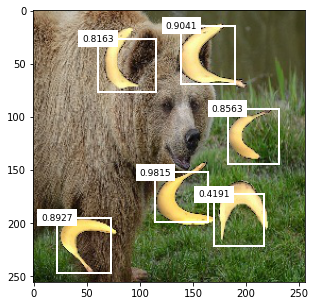

In [27]:
def display(img, output, threshold):
    
    output = output[output[:, 1] >= threshold]    # 置信度筛选
    keep = utils.nms(boxes=output[:, 2:6], scores=output[:, 1], iou_threshold=0.08)    # 非极大值抑制，iou比大于8%的抑制
    output = output[keep]
    print(output)
    
    plt.figure(figsize=(5, 5))
    fig = plt.imshow(img)
    for row in output:
        score = float(row[1])
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        utils.show_bboxes(fig.axes, bbox, '%.4f' % score, 'w')

display(img, output.cpu(), threshold=0.4)